In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import os
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import pandas as pd

In [ ]:
print(tf.__version__)

2.2.0


In [ ]:
!wget https://zenodo.org/record/259444/files/HASYv2.tar.bz2?download=1
# !tar xvzf HASYv2.tar.bz2

--2020-05-21 15:36:15--  https://zenodo.org/record/259444/files/HASYv2.tar.bz2?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34597561 (33M) [application/octet-stream]
Saving to: ‘HASYv2.tar.bz2?download=1’

HASYv2.tar.bz2?down 100%[===================>]  32.99M  73.9MB/s    in 0.4s    

2020-05-21 15:36:19 (73.9 MB/s) - ‘HASYv2.tar.bz2?download=1’ saved [34597561/34597561]



In [ ]:
!tar xvfj HASYv2.tar.bz2\?download\=1

Streaming output truncated to the last 5000 lines.
hasy-data/v2-120850.png
hasy-data/v2-156962.png
hasy-data/v2-143140.png
hasy-data/v2-144079.png
hasy-data/v2-164846.png
hasy-data/v2-36623.png
hasy-data/v2-42992.png
hasy-data/v2-53842.png
hasy-data/v2-87685.png
hasy-data/v2-103030.png
hasy-data/v2-02626.png
hasy-data/v2-27210.png
hasy-data/v2-158574.png
hasy-data/v2-79981.png
hasy-data/v2-29150.png
hasy-data/v2-132311.png
hasy-data/v2-148937.png
hasy-data/v2-145006.png
hasy-data/v2-118818.png
hasy-data/v2-114657.png
hasy-data/v2-80254.png
hasy-data/v2-93716.png
hasy-data/v2-133615.png
hasy-data/v2-105467.png
hasy-data/v2-103672.png
hasy-data/v2-62662.png
hasy-data/v2-146104.png
hasy-data/v2-124962.png
hasy-data/v2-18060.png
hasy-data/v2-14880.png
hasy-data/v2-32178.png
hasy-data/v2-10252.png
hasy-data/v2-35013.png
hasy-data/v2-146045.png
hasy-data/v2-153231.png
hasy-data/v2-01993.png
hasy-data/v2-160983.png
hasy-data/v2-00242.png
hasy-data/v2-136082.png
hasy-data/v2-112067.png
hasy-da

In [ ]:
!ls -ls

total 45676
    4 drwxr-xr-x 12 1000 1000     4096 Jan 24  2017  classification-task
 4972 drwxr-xr-x  2 1000 1000  5091328 Jan 24  2017  hasy-data
 6864 -rw-r--r--  1 1000 1000  7024687 Jan 24  2017  hasy-data-labels.csv
   28 -rwxrwxr-x  1 1000 1000    26723 Jan 28  2017  hasy_tools.py
33788 -rw-r--r--  1 root root 34597561 May  9 00:09 'HASYv2.tar.bz2?download=1'
    4 -rw-rw-r--  1 1000 1000     2065 Jan 28  2017  README.txt
    4 drwxr-xr-x  1 root root     4096 May 13 16:29  sample_data
    8 -rw-rw-r--  1 1000 1000     7243 Jan 19  2017  symbols.csv
    4 drwxrwxr-x  2 1000 1000     4096 Jan 28  2017  verification-task


In [ ]:
def get_num_lines(file_name):
  """ Counts the number of lines in the file. """
  f = open(file_name, 'r')
  counter = 0;
  for i in f:
      counter += 1
  return counter

def load_symbols(file_name):
  """ Reads the file having symbols and create two maps: `id2latex` and `latex2id`
  to encode the symbols and retrieve them easily. """

  id2latex = dict()
  latex2id = dict()
  f = open(file_name,'r')
  next(f)
  id = 0;
  for line in tqdm(f, total=get_num_lines(file_name)):
    _,latex,_,_ = line.split(',')
    if latex not in latex2id:
      latex2id[latex] = id
      id2latex[id] = latex
      id += 1
  return (id2latex,latex2id)


def load_data(label_file_name,latex2id):
  """ Reads the data file and create and return `data` and `labels` lists. """
  data = []
  labels = []
  f = open(label_file_name,'r')
  next(f)
  for line in tqdm(f, total=get_num_lines(label_file_name)):
    image_path,symbol_id,latex,_ = line.split(',')
    img = Image.open(os.path.join(image_path)).convert('L')
    img_array = np.asarray(img).astype('float32')
    data.append(img_array)
    labels.append(latex2id[latex])
  return (data,labels)
        

def load_train_data(file_name):
  data = []
  labels = []
  symbol2latex = dict()
  id2symbol = dict()
  symbol2id = dict()
  f = open(file_name,'r')
  next(f)
  id = 0;
  for line in tqdm(f, total=get_num_lines(file_name)):
       image_path,symbol_id,latex,_ = line.split(',')
       image_path = image_path.replace('../','')
       img = Image.open(os.path.join(image_path)).convert('L')
       img_array = np.asarray(img).astype('float32')
       data.append(img_array)
       if symbol_id not in symbol2latex:
           symbol2latex[symbol_id] = latex
           id2symbol[id] = symbol_id
           symbol2id[symbol_id] = id
           id += 1
       labels.append(symbol2id[symbol_id])
  return (data,labels,id2symbol,symbol2id,symbol2latex)


def load_test_data(file_name, symbol2id):
   data = []
   labels = []
   f = open(file_name,'r')
   next(f)
   for line in tqdm(f, total=get_num_lines(file_name)):
       image_path,symbol_id,latex,_ = line.split(',')
       image_path = image_path.replace('../','')
       img = Image.open(os.path.join(image_path)).convert('L')
       img_array = np.asarray(img).astype('float32')
       data.append(img_array)
       labels.append(symbol2id[symbol_id])
   return (data,labels)

        

In [ ]:
symbol_file_name = 'symbols.csv'
data_file_name   = 'hasy-data-labels.csv'
id2latex,latex2id = load_symbols(symbol_file_name)
data,labels = load_data(data_file_name,latex2id)

100%|█████████▉| 168233/168234 [00:35<00:00, 4736.74it/s]


\sum


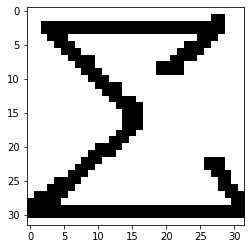

In [ ]:
sample = 1121
img = Image.fromarray(data[sample])
plt.imshow(img)
print(id2latex[labels[sample]])

In [ ]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2)
train_data = np.array(train_data).astype('float32')
test_data = np.array(test_data).astype('float32')
print(len(test_labels))

33647


In [ ]:
# Normalizing train and test data
normalized_train_data = train_data/255.0
normalized_test_data = test_data/255.0

# One-hot encoding of labels for train and test datasets
encoded_train_labels = np.array(keras.utils.to_categorical(train_labels))
encoded_test_labels = np.array(keras.utils.to_categorical(test_labels))

# Reshaping train and test sets, i.e. changing from (32, 32) to (32, 32, 1)
normalized_train_data = normalized_train_data.reshape(-1,32,32,1)
normalized_test_data = normalized_test_data.reshape(-1,32,32,1)

In [ ]:
print('Input shape = {}'.format(normalized_train_data.shape[1:]))
print('Number of classes =  {}'.format(encoded_train_labels.shape[1]))

Input shape = (32, 32, 1)
Number of classes =  369


In [ ]:
input_features = normalized_train_data.shape[1]
n_classes = encoded_train_labels.shape[1]
batch_size = 128
epochs = 15

model = Sequential()
model.add(Conv2D(128, (3,3), activation='relu', padding='same', input_shape=(input_features,input_features,1)))
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(128,(5,5), activation='relu', padding='same'))
model.add(Conv2D(128,(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       409728    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       409728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0

In [ ]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(normalized_train_data,encoded_train_labels, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(normalized_test_data,encoded_test_labels))

Epoch 1/15
1052/1052 [==============================] - 26s 25ms/step - loss: 2.7696 - accuracy: 0.3942 - val_loss: 1.0140 - val_accuracy: 0.7224
Epoch 2/15
1052/1052 [==============================] - 26s 25ms/step - loss: 1.4184 - accuracy: 0.6226 - val_loss: 0.7956 - val_accuracy: 0.7687
Epoch 3/15
1052/1052 [==============================] - 26s 25ms/step - loss: 1.1524 - accuracy: 0.6808 - val_loss: 0.7159 - val_accuracy: 0.7761
Epoch 4/15
1052/1052 [==============================] - 26s 25ms/step - loss: 1.0176 - accuracy: 0.7119 - val_loss: 0.6605 - val_accuracy: 0.8028
Epoch 5/15
1052/1052 [==============================] - 26s 25ms/step - loss: 0.9397 - accuracy: 0.7290 - val_loss: 0.6392 - val_accuracy: 0.8067
Epoch 6/15
1052/1052 [==============================] - 26s 25ms/step - loss: 0.8820 - accuracy: 0.7419 - val_loss: 0.6217 - val_accuracy: 0.8128
Epoch 7/15
1052/1052 [==============================] - 26s 25ms/step - loss: 0.8284 - accuracy: 0.7550 - val_loss: 0.6229 -

In [ ]:
score = model.evaluate(normalized_test_data, encoded_test_labels, verbose=0)
print('Test loss: {:.3f}'.format(score[0]))
print('Test accuracy: {:.2f}%'.format(score[1] * 100))

Test loss: 0.570
Test accuracy: 82.38%


In [ ]:
## Test a random test example
sample = 16180
x_test = normalized_test_data[sample].reshape(1,32,32,1)
x_test_label = test_labels[sample]
print(x_test.shape)
print(x_test_label)
prediction = model.predict(x_test)
prediction_label = prediction.argmax(axis=1)
print(prediction_label)

(1, 32, 32, 1)
301
[301]
